## Inicialização

In [1]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content'
# !chmod 600 '/content/kaggle.json'
# !kaggle datasets download -d mariafrenti/age-prediction
# !unzip -q age-prediction.zip
# !rm age-prediction.zip

 99% 2.01G/2.03G [00:22<00:00, 92.4MB/s]
100% 2.03G/2.03G [00:22<00:00, 96.0MB/s]


### Importação e configuração de seed

In [1]:
SEED = 1001

import numpy as np
import pandas as pd
import os
from os import path
os.environ['PYTHONHASHSEED'] = str(SEED)
import tensorflow as tf
import random as python_random
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import image_utils as imgutils
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import math
# Typings
from typing import Tuple, Callable, List, Union, Dict, Iterable, Iterator, Optional
from tensorflow.python.data.ops.dataset_ops import BatchDataset
import functools
import seaborn as sns
from glob2 import glob
from joblib import load, dump


# Padronizando a aleatoriedade
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

### Carregamento de dados

In [2]:
NUM_OF_COLOR_CHANNELS = 3
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
INPUT_SHAPE = (*IMAGE_SIZE, NUM_OF_COLOR_CHANNELS)
BATCH_INPUT_SHAPE = (None, *INPUT_SHAPE)

'''
    Retorna um Dataset com base nos arquivos dos diretórios.
    - path: caminho base para as pastas
'''
def _load_data(path: str, subset: str = None, validation_split: float = None) -> tf.data.Dataset:
    return keras.preprocessing.image_dataset_from_directory(
        path,
        seed=SEED,
        validation_split=validation_split,
        subset=subset,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
_20to50_dir = path.join("20-50", "20-50")
_1to100_dir = path.join("age_prediction_up", "age_prediction")


'''
    Retorna um Dataset com as imagens e labels já apropriados para treinamento
    - all_ages: se deve ser usado o diretório com idades de 1 a 100
    - train: se deve ser usado o conjunto de treino
    (será usado teste caso contrário)
    - regression: se os labels devem ser transformados para tarefas de regressão
    (será transformado para classificação caso contrário)
'''
def load_data(all_ages: bool, train: bool, regression: bool, subset: str = None, validation_split: float = None) -> tf.data.Dataset:
    base_dir = _1to100_dir if all_ages else _20to50_dir
    folder = "train" if train else "test"
    age_count = 100 if all_ages else 31
    data = _load_data(path.join(base_dir, folder), subset, validation_split)
    if regression:
        return data.map(lambda x, y: (x, y / (age_count - 1)))
    return data.map(lambda x, y: (x, tf.one_hot(y, depth=age_count)))

In [3]:

''' Retorna uma np.ndarray com todos os caminhos até as imagens '''
def get_image_paths(all_ages: bool, train: bool) -> np.ndarray:
    base_dir = _1to100_dir if all_ages else _20to50_dir
    folder = "train" if train else "test"
    return np.array(sorted(glob(path.join(base_dir, folder, '*', '*.jpg'))))

'''
    Retorna a imagem e o label associado a um caminho.
    O label já é transformado apropriadamente
'''
def load_image(path: str, regression: bool, num_of_groups: Optional[int] = None):
    parts = path.split(os.sep)
    age = int(parts[3])
    all_ages = parts[0] != '20-50'
    age_count = 100 if all_ages else 31
    offset = 1 if all_ages else 20
    if regression:
        label = tf.convert_to_tensor((age - offset) / (age_count - 1))
    else:
        num_of_groups = num_of_groups if num_of_groups is not None else age_count
        _label = int((age - offset) / age_count * num_of_groups)
        if _label >= num_of_groups:
            _label = num_of_groups - 1
        label = tf.one_hot(_label, depth=num_of_groups)
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    return image, label

'''
    Retorna um gerador que pode ser usado para iterar por todas as imagens
    nos caminhos especificados.
    Construa um Dataset com tf.data.Dataset.from_generator
'''
def build_images_generator(paths: List[str], regression: bool, num_of_groups: Optional[int] = None):
    def gen():
        i = 0
        num_of_files = len(paths)
        while i < num_of_files:
            yield load_image(paths[i], regression, num_of_groups)
            i += 1
    return gen

'''
    Retorna um Dataset com todas as imagens e seus respectivos labels (já transformados)

'''
def build_ds_from_paths(paths: List[str], regression: bool, num_of_groups: Optional[int] = None, batch_size=BATCH_SIZE) -> tf.data.Dataset:
    all_ages = paths[0].split(os.sep)[0] != '20-50'
    age_count = 100 if all_ages else 31
    num_of_groups = num_of_groups if num_of_groups is not None else age_count
    label_shape = () if regression else (num_of_groups,)
    input_shape = INPUT_SHAPE
    return tf.data.Dataset.from_generator(
        build_images_generator(paths, regression, num_of_groups),
        output_types=(tf.uint8, tf.float32), 
        output_shapes=(input_shape, label_shape),
    ).batch(BATCH_SIZE)

def build_ds_from_index(index: List[int], all_ages: bool, train: bool, regression: bool, num_of_groups: Optional[int] = None, batch_size=BATCH_SIZE) -> tf.data.Dataset:
    paths = get_image_paths(all_ages, train)[index]
    return build_ds_from_paths(paths, regression, num_of_groups, batch_size)

'''
    Mapeia labels ou predições, que são valores em [0, 1], para idades.
    Na classificação, há codificação one-hot

    A idade retornada na classificação é aquela associada à classe
    com maior propabilidade.
'''
def map_to_ages(labels, all_ages: bool, regression: bool):
    scale = (99 if all_ages else 30) if regression else 1
    offset = 1 if all_ages else 20
    if not regression:
        labels = np.argmax(labels, axis=-1)
    return labels * scale + offset


In [4]:
SAMPLE_SIZE = 5000
validation_split = 0.2

train_paths = get_image_paths(all_ages=False, train=True)
train_paths_sample = np.random.choice(train_paths, SAMPLE_SIZE)

test_paths = get_image_paths(all_ages=False, train=False)

tr_paths, valid_paths = train_test_split(train_paths, test_size=validation_split, random_state=SEED, shuffle=True)
tr_paths_sample, valid_paths_sample = train_test_split(train_paths_sample, test_size=validation_split, random_state=SEED, shuffle=True)

sample_ds_train = build_ds_from_paths(tr_paths_sample, regression=True)
sample_ds_valid = build_ds_from_paths(valid_paths_sample, regression=True)

NUM_OF_GROUPS = 3 # [20, 30) | [30, 40) | [40, 50]
sample_ds_train_c = build_ds_from_paths(tr_paths_sample, regression=False, num_of_groups=NUM_OF_GROUPS)
sample_ds_valid_c = build_ds_from_paths(valid_paths_sample, regression=False, num_of_groups=NUM_OF_GROUPS)

ds_train_c = build_ds_from_paths(tr_paths, regression=False, num_of_groups=NUM_OF_GROUPS)
ds_valid_c = build_ds_from_paths(valid_paths, regression=False, num_of_groups=NUM_OF_GROUPS)

ds_train_r = build_ds_from_paths(tr_paths, regression=True)
ds_valid_r = build_ds_from_paths(valid_paths, regression=True)
ds_fulltrain_r = ds_train_r.concatenate(ds_valid_r)
ds_test_r = build_ds_from_paths(test_paths, regression=True)


### Distribuição dos dados

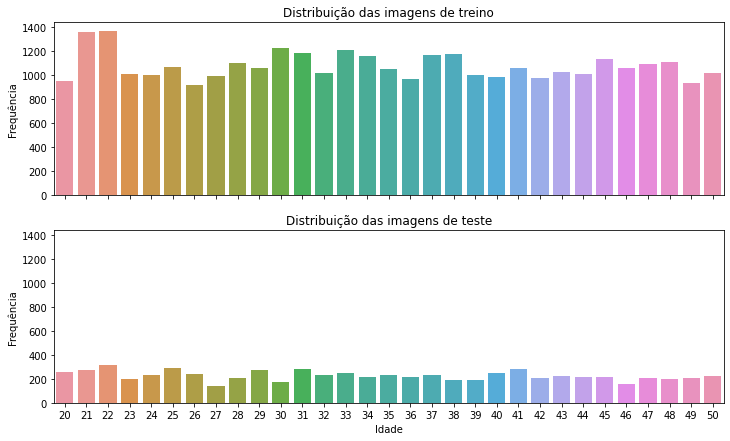

In [6]:
def count_images(train: bool, age: int):
    folder = 'train' if train else 'test'
    return len(glob(path.join('20-50', '20-50', folder, str(age), '*.jpg')))

train_images_per_age = [count_images(train=True, age=age) for age in range(20, 51)]
test_images_per_age = [count_images(train=False, age=age) for age in range(20, 51)]

def plot_distribution(x, train_count, other_count, test: bool = True):
    _, axs = plt.subplots(figsize=(12, 7), nrows=2, sharex=True, sharey=True)
    axs[0].set_title('Distribuição das imagens de treino')
    axs[0].set_ylabel('Frequência')
    axs[1].set_xlabel('Idade')
    axs[1].set_ylabel('Frequência')
    axs[1].set_title(f'Distribuição das imagens de {"teste" if test else "validação"}')
    sns.barplot(x=x, y=train_count, ax=axs[0])
    sns.barplot(x=x, y=other_count, ax=axs[1])

plot_distribution(list(range(20, 51)), train_images_per_age, test_images_per_age)

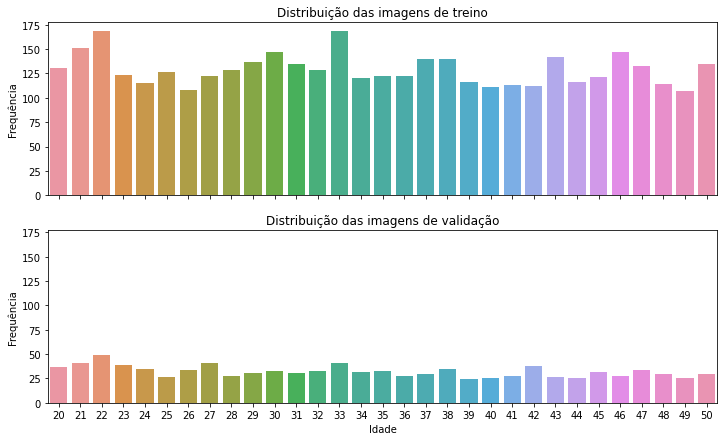

In [7]:
_train_images_per_age = np.bincount([int(map_to_ages(y, False, regression=True)) - 20 for _, y in sample_ds_train.unbatch()])
_valid_images_per_age = np.bincount([int(map_to_ages(y, False, regression=True)) - 20 for _, y in sample_ds_valid.unbatch()])
plot_distribution(list(range(20, 51)), _train_images_per_age, _valid_images_per_age, test=False)

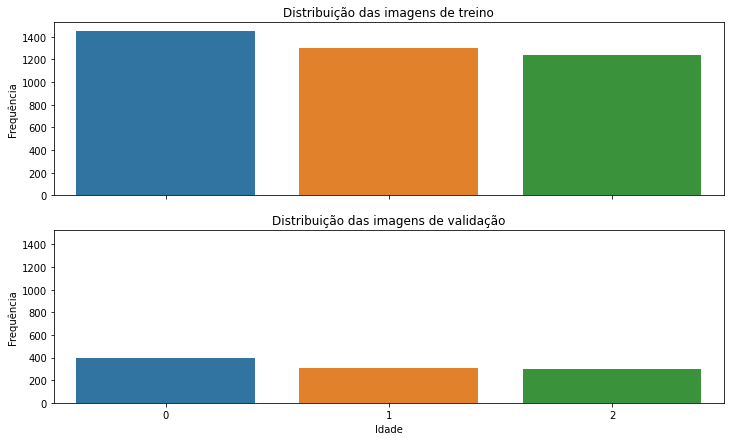

In [8]:
_train_images_per_age = np.bincount([np.argmax(y) for _, y in sample_ds_train_c.unbatch()])
_valid_images_per_age = np.bincount([np.argmax(y) for _, y in sample_ds_valid_c.unbatch()])
plot_distribution([0, 1, 2], _train_images_per_age, _valid_images_per_age, test=False)

In [9]:
_valid_images_per_age

array([394, 311, 295], dtype=int64)

### Pré-processamento

In [10]:
_only_normalization = keras.Sequential([
    layers.Rescaling(1./255, batch_input_shape=BATCH_INPUT_SHAPE)
], name='only_normalization')

def build_preprocess(strenght: float = 0.1):
    if strenght == 0:
        return keras.Sequential(
            [
             layers.Resizing(*IMAGE_SIZE, batch_input_shape=BATCH_INPUT_SHAPE),
             _only_normalization,
            ], name='preprocess'
        )
    return keras.Sequential(
    [
        layers.Resizing(*IMAGE_SIZE, batch_input_shape=BATCH_INPUT_SHAPE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(strenght),
        layers.RandomTranslation(strenght, strenght),
        layers.RandomZoom(strenght, strenght),
        layers.RandomContrast(strenght),
        _only_normalization,
    ], name='preprocess'
)

### Visualização de exemplos de entrada

In [11]:
def batchify(image: np.ndarray) -> np.ndarray:
    if len(image.shape) == len(INPUT_SHAPE):
        # o modelo (incluindo pré-processamento) espera a entrada em mini-batches
        # caso uma única imagem seja passada, modificamos seu formato
        # para 1 batch de 1 imagem
        image = np.expand_dims(image, axis=0)
    return image

'''
    Exibe uma image.
'''
def plot_single_image(image: np.ndarray, age: Optional[int] = None, apply=None, ax=None):
    if apply is not None:
        image = apply(batchify(image))[0]
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(image)
    if age is not None:
        ax.set_title(age)
    ax.axis("off")

def plot_samples(images, ages: Iterable[int], all_ages: bool, regression: bool, ncols=4, apply=None):
    if ncols > len(images):
        ncols = len(images)
    nrows = math.ceil(len(images) / ncols)
    N = nrows * ncols
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2 * ncols, 2.5 * nrows), squeeze=False)
    axs = axs.ravel()
    for i, (image, label) in enumerate(zip(images, ages)):
        if i >= N:
            break
        image = image.numpy()
        if apply is not None:
            image = apply(batchify(image))[0]
        axs[i].imshow(image)
        age = map_to_ages(label, all_ages=all_ages, regression=regression)
        axs[i].set_title(int(float(age)))
        axs[i].axis("off")
    
def extract_first_batch(ds):
    for image, age in ds:
        return image, age

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


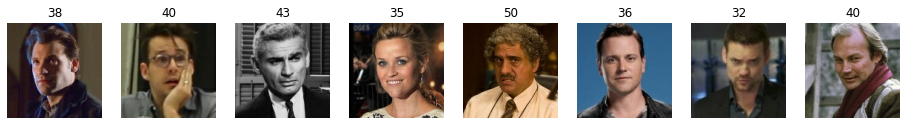

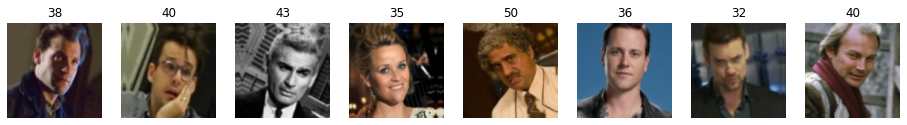

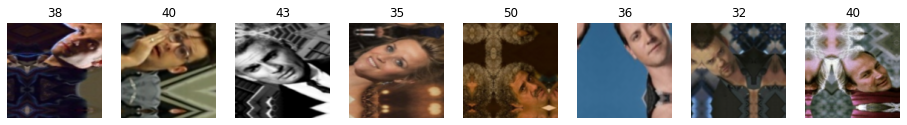

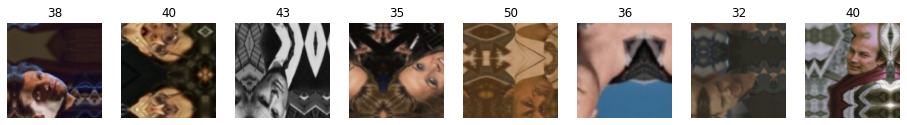

In [8]:
_images, _ages = extract_first_batch(sample_ds_train)
plot_samples(_images[:8], _ages[:8], all_ages=False, regression=True, ncols=8)
plot_samples(_images[:8], _ages[:8], all_ages=False, regression=True, ncols=8, apply=build_preprocess(0.1))
plot_samples(_images[:8], _ages[:8], all_ages=False, regression=True, ncols=8, apply=build_preprocess(0.3))
plot_samples(_images[:8], _ages[:8], all_ages=False, regression=True, ncols=8, apply=build_preprocess(0.5))

In [22]:
# !unzip modelR.zip

Archive:  finalmodelR.zip
   creating: finalmodelR/


In [30]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
#!unzip /content/drive/MyDrive/modelR.zip

Archive:  /content/drive/MyDrive/modelR.zip
   creating: savedmodel/
   creating: savedmodel/assets/
  inflating: savedmodel/keras_metadata.pb  
   creating: savedmodel/variables/
  inflating: savedmodel/variables/variables.data-00000-of-00001  
  inflating: savedmodel/variables/variables.index  
  inflating: savedmodel/saved_model.pb  


In [13]:
modelR = keras.models.load_model('finalmodelR')

In [14]:
modelR.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 preprocess (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                         

In [17]:
convModelsR = [
    keras.models.Model(inputs = modelR.input, outputs = modelR.layers[i].output)
    for i in range(2, 6)
]
def computeFilters(output):
    return np.moveaxis(output, -1, 0)
def showFilters(filters, shape=(4, 8)):
    fig, axs = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=(16, 6))
    axs = axs.ravel()
    for i in range(shape[0] * shape[1]):
        plot_single_image(filters[i], ax=axs[i])

In [32]:
def load_image_to_predict(img_path, show=False, normalized=True):
    img = imgutils.load_img(img_path, target_size=(128, 128))
    img_tensor = imgutils.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    if normalized:
        img_tensor /= 255.

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

def gen_predict_dataset(imgs_path, normalized=True):
    for filename in os.listdir(imgs_path):
        if path.isdir(path.join(imgs_path, filename)):
            for img in gen_predict_dataset(path.join(imgs_path, filename), normalized=normalized):
                yield img
        else:
            yield load_image_to_predict(path.join(imgs_path, filename), normalized=normalized)

In [33]:
_images = list(gen_predict_dataset('to_predict', normalized=False))
outputs = [
    model.predict((image for image in _images))
    for model in convModelsR
]

16/16 [==============================] - 0s 4ms/step


In [37]:
_predictions = modelR.predict((image for image in _images))

16/16 [==============================] - 0s 13ms/step


In [38]:
_ages = map_to_ages(_predictions, all_ages=False, regression=True)

In [39]:
_ages[0], _ages[2], _ages[6], _ages[-1]

(array([35.316708], dtype=float32),
 array([34.799274], dtype=float32),
 array([38.11154], dtype=float32),
 array([38.274178], dtype=float32))

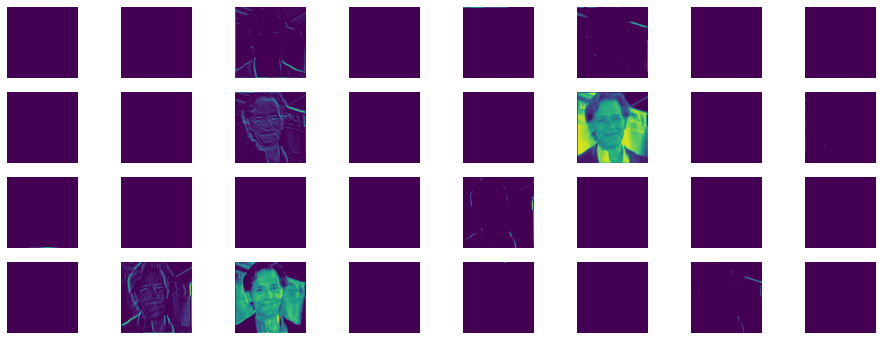

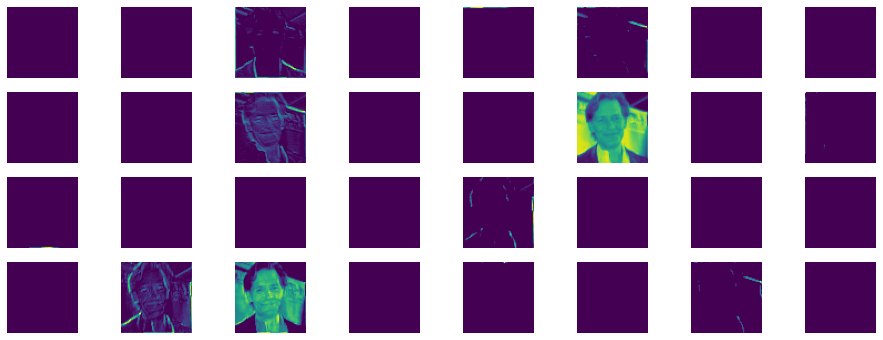

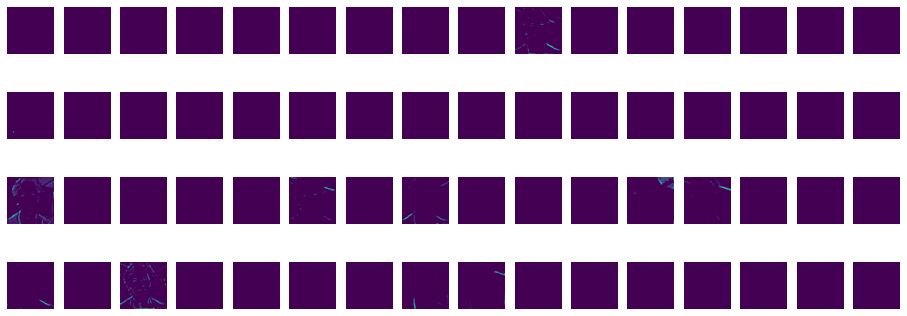

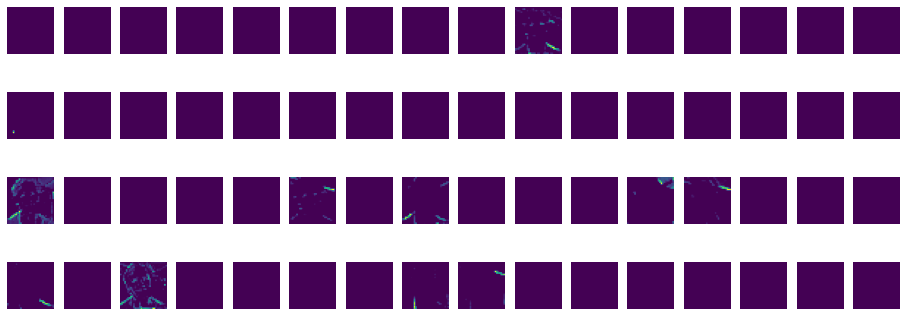

In [34]:
for output, shape in zip(outputs, [(4, 8), (4, 8), (4, 16), (4, 16)]):
    showFilters(computeFilters(output[-1]), shape)

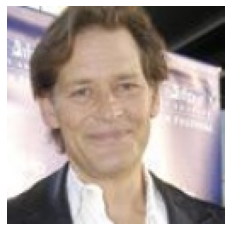

In [43]:
plot_single_image(_images[-1].reshape(128, 128, 3) / 255.)

In [50]:
# convModelR2 = keras.models.Model(inputs = modelR.input, outputs = modelR.layers[3].output)

In [51]:
# outputs2 = convModelR2(_images)

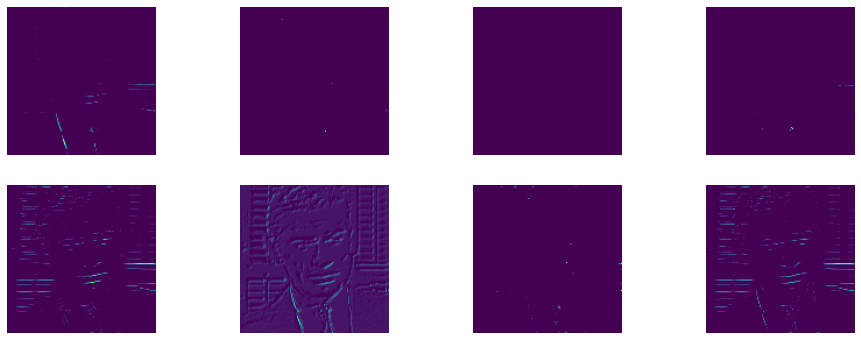

In [53]:
# showFilters(computeFilters(outputs2[2]))

In [47]:
# convModelR3 = keras.models.Model(inputs = modelR.input, outputs = modelR.layers[4].output)

In [48]:
# outputs3 = convModelR3(_images)

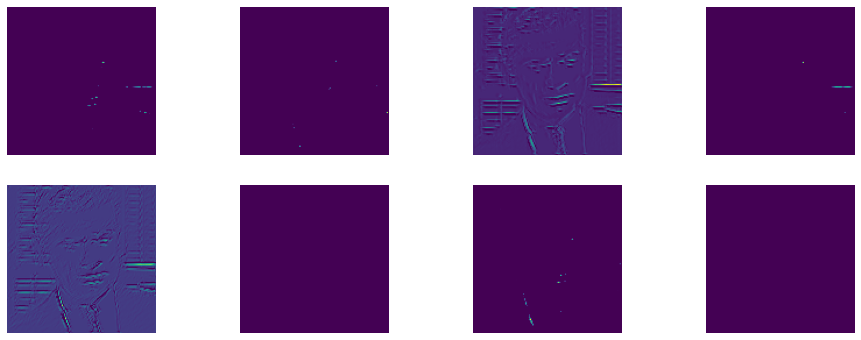

In [54]:
# showFilters(computeFilters(outputs3[2]))

In [66]:
# poolModel = keras.models.Model(inputs = modelR.input, outputs = modelR.layers[6].output)

In [67]:
# poolOutputs = poolModel(_images)

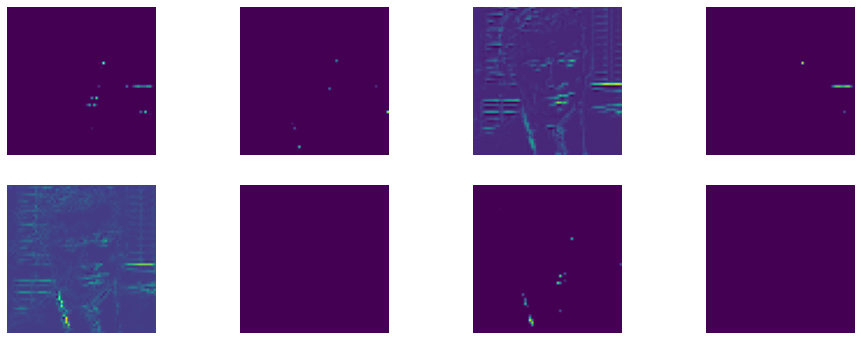

In [69]:
# showFilters(computeFilters(poolOutputs[2]))

## Modelos

### Construção da CNN

In [49]:
def build_model(
    inputs,
    num_of_conv_layers_per_block: int,
    num_of_blocks: int,
    initial_filter: int,
    num_of_hidden_layers: int,
    neurons_per_hidden_layer: int, 
    dense_activation: str,
    output_activation: str,
    dropout: Optional[float] = None,
    # se o número de filtros é constante ou dobra a cada bloco
    fixed_size_filter: bool = False,
    use_batch_normalization = False,
    last_dense_neurons_count = 1,
    preprocess_strenght = 0.1,
):
    dropout = None if dropout == 0 else dropout

    KERNEL_SIZE = 3
    CONV_ACTIVATION = 'relu'
    CONV_PADDING = 'same'
    POOL_SIZE = 2
    BATCH_INPUT_SHAPE = (*IMAGE_SIZE, 3)

    x = build_preprocess(preprocess_strenght)(inputs)

    all_blocks = []
    filters = initial_filter
    for i in range(num_of_blocks):
        block = [
            layers.Conv2D(
                filters,
                KERNEL_SIZE,
                padding=CONV_PADDING,
                batch_input_shape=BATCH_INPUT_SHAPE,
                activation=CONV_ACTIVATION
            )
            for j in range(num_of_conv_layers_per_block)
        ]
        if use_batch_normalization:
            block.append(layers.BatchNormalization())
        block.append(layers.MaxPooling2D(pool_size=POOL_SIZE))

        all_blocks.append(block)
        if not fixed_size_filter:
            filters *= 2
    
    for block in all_blocks:
        for layer in block:
            x = layer(x)
    
    
    x = layers.Flatten()(x)

    for i in range(num_of_hidden_layers):
        x = layers.Dense(neurons_per_hidden_layer, activation=dense_activation)(x)
        if dropout is not None:
            x = layers.Dropout(dropout)(x)

    x = layers.Dense(last_dense_neurons_count, activation=output_activation)(x)
        
    return keras.models.Model(inputs=inputs, outputs=x)

### Geração de hiperparâmetros aleatórios

In [50]:
def get_random_hyperparameters(count: int, seed: int = 3621264):
    rng = np.random.default_rng(seed=seed)
    for i in range(count):
        yield {
            'num_of_conv_layers_per_block': rng.choice([1, 2, 3]),
            'num_of_blocks': rng.choice([1, 2, 3]),
            'num_of_hidden_layers': rng.choice([1, 2, 3]),
            'neurons_per_hidden_layer': rng.choice([16, 32, 64, 128, 256]),
            'initial_filter': rng.choice([8, 16, 32, 64]),
            'dropout': rng.choice([0, 0.1, 0.5]),
            'fixed_size_filter': rng.choice([False, True]),
            'use_batch_normalization': rng.choice([False, True]),
            'dense_activation': rng.choice(['tanh', 'relu']),
        }

list(get_random_hyperparameters(2, seed=1))

[{'num_of_conv_layers_per_block': 2,
  'num_of_blocks': 2,
  'num_of_hidden_layers': 3,
  'neurons_per_hidden_layer': 256,
  'initial_filter': 8,
  'dropout': 0.0,
  'fixed_size_filter': True,
  'use_batch_normalization': True,
  'dense_activation': 'tanh'},
 {'num_of_conv_layers_per_block': 1,
  'num_of_blocks': 3,
  'num_of_hidden_layers': 2,
  'neurons_per_hidden_layer': 32,
  'initial_filter': 64,
  'dropout': 0.0,
  'fixed_size_filter': False,
  'use_batch_normalization': True,
  'dense_activation': 'relu'}]

### Treino do modelo de regressão

#### Inicialização

In [51]:
def train_model_R(model, epochs: int, train_data: tf.data.Dataset, valid_data: tf.data.Dataset):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.MSE
    model.compile(optimizer=optimizer, loss=loss)
    history = model.fit(train_data, epochs=epochs, validation_data=valid_data)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    return history


In [52]:
class Losses:
    @staticmethod
    def RMSE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.sqrt(np.mean((real - pred) ** 2))

    @staticmethod
    def MAE(real: np.ndarray, pred: np.ndarray) -> float:
        return np.mean(np.abs(real - pred))
    
    @staticmethod
    def regression(real: np.ndarray, pred: np.ndarray) -> pd.Series:
        return pd.Series({
            'RMSE': Losses.RMSE(real, pred),
            'MAE': Losses.MAE(real, pred),
        }, name='losses')

In [53]:
train_data_R = sample_ds_train
valid_data_R = sample_ds_valid
inputs_R = layers.Input(shape=(None, None, 3), dtype='uint8')

In [ ]:
def RandomSearch_R(tr, val, model_amount: int = 30, epochs: int = 10, n_folds: int = 5, preprocess_strenght = 0.1):
    models = []
    inputs_R = layers.Input(shape=(None, None, 3), dtype='uint8')
    loss_R = np.ndarray(model_amount)
    hyperparams_R = list(get_random_hyperparameters(count=model_amount))
    for i in range(model_amount):
        print(f"Hiperparâmetros Selecionados:\n{hyperparams_R[i]}")
        model_R = build_model(inputs_R, **hyperparams_R[i], output_activation = 'sigmoid', preprocess_strenght=preprocess_strenght)
        history_R = train_model_R(model_R, epochs, train_data = tr, valid_data = val)
        models.append(model_R)
        loss_R[i] = history_R.history['val_loss'][-1]
    idx_R = np.argmin(loss_R)
    selected_hyperparams = hyperparams_R[idx_R]
    return selected_hyperparams, models[idx_R]

#### Sem pré-processamento
Só foi utilizada reescala e normalização.

In [ ]:
selected_hyper0, selected_model0 = RandomSearch_R(train_data_R, valid_data_R, preprocess_strenght=0)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 32, 'initial_filter': 8, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 10s 65ms/step - loss: 0.1100 - val_loss: 0.0911
Epoch 2/10
125/125 [==============================] - 8s 65ms/step - loss: 0.0938 - val_loss: 0.1071
Epoch 3/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0876 - val_loss: 0.1217
Epoch 4/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0830 - val_loss: 0.1069
Epoch 5/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0753 - val_loss: 0.1017
Epoch 6/10
125/125 [==============================] - 8s 65ms/step - loss: 0.0698 - val_loss: 0.0948
Epoch 7/10
125/125 [==============================] - 8s 64ms/step - loss: 0.0653 - val_loss: 0.0879
Epoch 8/10
125/125 [==

In [ ]:
print(selected_hyper0)

#### Com pré-processamento leve
Há camadas de aleatoriedade que distorcem as entradas, mas não de maneira tão forte

In [ ]:
# Pré-processamento leve
selected_hyper, selected_model = RandomSearch_R(train_data_R, valid_data_R)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 32, 'initial_filter': 8, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 22s 67ms/step - loss: 0.1174 - val_loss: 0.0901
Epoch 2/10
125/125 [==============================] - 8s 61ms/step - loss: 0.1040 - val_loss: 0.1009
Epoch 3/10
125/125 [==============================] - 8s 66ms/step - loss: 0.1033 - val_loss: 0.1101
Epoch 4/10
125/125 [==============================] - 8s 61ms/step - loss: 0.1012 - val_loss: 0.0886
Epoch 5/10
125/125 [==============================] - 8s 63ms/step - loss: 0.0993 - val_loss: 0.0888
Epoch 6/10
125/125 [==============================] - 10s 79ms/step - loss: 0.0988 - val_loss: 0.0863
Epoch 7/10
125/125 [==============================] - 8s 65ms/step - loss: 0.0965 - val_loss: 0.0852
Epoch 8/10
125/125 [=

In [ ]:
print(selected_hyper)

#### Com pré-processamento forte

In [ ]:
# Pré-processamento forte
selected_hyper2, selected_model2 = RandomSearch_R(train_data_R, valid_data_R, preprocess_strenght=0.5)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 2, 'num_of_blocks': 3, 'num_of_hidden_layers': 1, 'neurons_per_hidden_layer': 32, 'initial_filter': 8, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': True, 'dense_activation': 'tanh'}
Epoch 1/10
125/125 [==============================] - 9s 62ms/step - loss: 0.1137 - val_loss: 0.0902
Epoch 2/10
125/125 [==============================] - 7s 60ms/step - loss: 0.1022 - val_loss: 0.1015
Epoch 3/10
125/125 [==============================] - 7s 58ms/step - loss: 0.1020 - val_loss: 0.1085
Epoch 4/10
125/125 [==============================] - 7s 60ms/step - loss: 0.1017 - val_loss: 0.0985
Epoch 5/10
125/125 [==============================] - 7s 60ms/step - loss: 0.0991 - val_loss: 0.0880
Epoch 6/10
125/125 [==============================] - 7s 58ms/step - loss: 0.0986 - val_loss: 0.0876
Epoch 7/10
125/125 [==============================] - 7s 60ms/step - loss: 0.0968 - val_loss: 0.0880
Epoch 8/10
125/125 [===

In [ ]:
print(selected_hyper2)

In [ ]:
selected_model.save('savedmodel')
!zip -r savedmodel.zip savedmodel
from google.colab import files
files.download('savedmodel.zip')

INFO:tensorflow:Assets written to: savedmodel/assets
  adding: savedmodel/ (stored 0%)
  adding: savedmodel/assets/ (stored 0%)
  adding: savedmodel/keras_metadata.pb (deflated 93%)
  adding: savedmodel/variables/ (stored 0%)
  adding: savedmodel/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: savedmodel/variables/variables.index (deflated 70%)
  adding: savedmodel/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Treino Final - Regressão

Treino do modelo de regressão com os hiperparâmetros selecionados e todo o conjunto de treino

In [ ]:
selected_hyper_R = {
    'num_of_conv_layers_per_block': 1,
    'num_of_blocks': 2,
    'num_of_hidden_layers': 1,
    'neurons_per_hidden_layer': 16,
    'initial_filter': 32,
    'dropout': 0.1,
    'fixed_size_filter': False,
    'use_batch_normalization': False,
    'dense_activation': 'tanh'
}

Epoch 1/10
1045/1045 [==============================] - 91s 73ms/step - loss: 0.0949 - val_loss: 0.0887
Epoch 2/10
1045/1045 [==============================] - 57s 55ms/step - loss: 0.0867 - val_loss: 0.0885
Epoch 3/10
1045/1045 [==============================] - 56s 54ms/step - loss: 0.0862 - val_loss: 0.0892
Epoch 4/10
1045/1045 [==============================] - 57s 54ms/step - loss: 0.0859 - val_loss: 0.0914
Epoch 5/10
1045/1045 [==============================] - 58s 55ms/step - loss: 0.0855 - val_loss: 0.0881
Epoch 6/10
1045/1045 [==============================] - 57s 54ms/step - loss: 0.0854 - val_loss: 0.0869
Epoch 7/10
1045/1045 [==============================] - 56s 54ms/step - loss: 0.0853 - val_loss: 0.0876
Epoch 8/10
1045/1045 [==============================] - 56s 54ms/step - loss: 0.0849 - val_loss: 0.0876
Epoch 9/10
1045/1045 [==============================] - 56s 54ms/step - loss: 0.0846 - val_loss: 0.0861
Epoch 10/10
1045/1045 [==============================] - 56s 54m

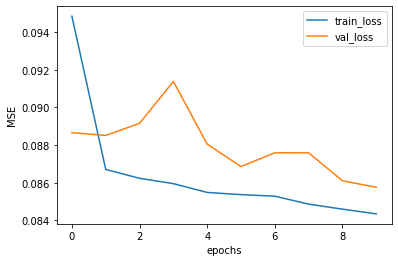

INFO:tensorflow:Assets written to: finalmodelR/assets


In [ ]:
final_model_R = build_model(inputs_R, **selected_hyper_R, output_activation = 'sigmoid', preprocess_strenght = 0.1)
history_final_R = train_model_R(final_model_R, epochs = 10, train_data = ds_fulltrain_r, valid_data = ds_test_r)
final_model_R.save('finalmodelR')

### Modelo de classificação com 3 classes

#### Inicialização

In [ ]:
def train_model_C(model, epochs: int, train_data: tf.data.Dataset, valid_data: tf.data.Dataset):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    loss = keras.losses.categorical_crossentropy
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model.fit(train_data, epochs=epochs, validation_data=valid_data)

In [ ]:
def RandomSearch_C(tr, val, model_amount: int = 30, epochs: int = 10, num_classes: int = 31):
  models = []
  inputs_C = layers.Input(shape=(None, None, 3), dtype='uint8')
  score_C = np.ndarray(model_amount)
  hyperparams_C = list(get_random_hyperparameters(count=model_amount, seed=11))
  for i in range(model_amount):
    print(f"Hiperparâmetros Selecionados:\n{hyperparams_C[i]}")
    model_C = build_model(inputs_C, **hyperparams_C[i], output_activation = 'softmax', last_dense_neurons_count=num_classes, preprocess_strenght=0.5)
    history_C = train_model_C(model_C, epochs, train_data = tr, valid_data = val)
    models.append(model_C)
    score_C[i] = history_C.history['val_accuracy'][-1]
  idx_C = np.argmax(score_C)
  selected_hyperparams = hyperparams_C[idx_C]
  return selected_hyperparams, models[idx_C]

In [ ]:
train_data_C = ds_train_c
valid_data_C = ds_valid_c
inputs_C = layers.Input(shape=(None, None, 3), dtype='uint8')

#### Treino

In [ ]:
selected_hyper_C, selected_model_C = RandomSearch_C(train_data_C, valid_data_C, num_classes=3, model_amount=5)

Hiperparâmetros Selecionados:
{'num_of_conv_layers_per_block': 1, 'num_of_blocks': 1, 'num_of_hidden_layers': 3, 'neurons_per_hidden_layer': 64, 'initial_filter': 32, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': False, 'dense_activation': 'tanh'}
Epoch 1/10
836/836 [==============================] - 63s 74ms/step - loss: 1.1268 - accuracy: 0.3428 - val_loss: 1.1057 - val_accuracy: 0.3643
Epoch 2/10
836/836 [==============================] - 51s 61ms/step - loss: 1.1092 - accuracy: 0.3413 - val_loss: 1.0989 - val_accuracy: 0.3643
Epoch 3/10
836/836 [==============================] - 51s 61ms/step - loss: 1.1038 - accuracy: 0.3452 - val_loss: 1.0990 - val_accuracy: 0.3643
Epoch 4/10
836/836 [==============================] - 51s 61ms/step - loss: 1.1015 - accuracy: 0.3455 - val_loss: 1.0995 - val_accuracy: 0.3643
Epoch 5/10
836/836 [==============================] - 51s 61ms/step - loss: 1.1003 - accuracy: 0.3439 - val_loss: 1.0983 - val_accuracy: 0.3643
Epoch 6/

In [ ]:
print(selected_hyper_C)

{'num_of_conv_layers_per_block': 1, 'num_of_blocks': 1, 'num_of_hidden_layers': 3, 'neurons_per_hidden_layer': 64, 'initial_filter': 32, 'dropout': 0.1, 'fixed_size_filter': True, 'use_batch_normalization': False, 'dense_activation': 'tanh'}


#### Avaliação

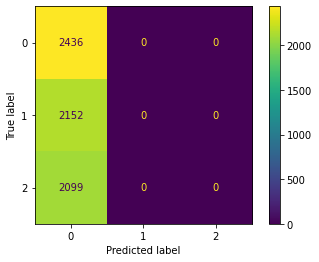

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
_predictions_C = np.argmax(selected_model_C.predict(valid_data_C), axis=-1)
_expected_C = np.argmax([y for _, y in valid_data_C.unbatch()], axis=-1)
_predictions_C.shape, _expected_C.shape
ConfusionMatrixDisplay.from_predictions(_expected_C, _predictions_C)

In [ ]:
selected_model_C.save('savedmodelc')
!zip -r savedmodelc.zip savedmodelc
from google.colab import files
files.download('savedmodelc.zip')

INFO:tensorflow:Assets written to: savedmodelc/assets
updating: savedmodelc/ (stored 0%)
updating: savedmodelc/assets/ (stored 0%)
updating: savedmodelc/keras_metadata.pb (deflated 93%)
updating: savedmodelc/variables/ (stored 0%)
updating: savedmodelc/variables/variables.data-00000-of-00001 (deflated 12%)
updating: savedmodelc/variables/variables.index (deflated 71%)
updating: savedmodelc/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Modelo interpretadores de regressão
Utiliza camadas de convolução já aprendidas para extrair atributos das imagens

In [59]:
conv_model_R = keras.models.Model(inputs = final_model_R.input, outputs = final_model_R.get_layer(name = 'flatten').output)

In [60]:
new_train_data_R = conv_model_R.predict(train_data_R)
new_val_data_R = conv_model_R.predict(valid_data_R)
print(new_train_data_R.shape)
print(new_val_data_R.shape)

32/32 [==============================] - 1s 31ms/step
(4000, 65536)
(1000, 65536)


In [61]:
batches_train_R = np.array([y for _, y in train_data_R])
labels_train_R = batches_train_R.flatten()
batches_val_R = [y.numpy() for _, y in valid_data_R]
batch = batches_val_R[0]
i = 0
for b in batches_val_R:
  if (i != 0):
    batch = np.r_[batch, b]
  i = i + 1
labels_val_R = batch
print(labels_train_R.shape)
print(labels_val_R.shape)

(4000,)
(1000,)


In [62]:
new_train_data_R = normalize(new_train_data_R)
new_val_data_R = normalize(new_val_data_R)

In [63]:
def train_simple_model(epochs: int  = 1000):
    train_data = new_train_data_R
    val_data = new_val_data_R
    train_labels = labels_train_R
    val_labels = labels_val_R
    sgd = SGDRegressor(penalty = 'elasticnet', learning_rate = 'constant')
    training_mse = []
    validation_mse = []
    for epoch in range(epochs):
        sgd.partial_fit(train_data, train_labels) 
        Y_pred_T = sgd.predict(train_data)
        curr_train_score = np.mean((train_labels - Y_pred_T)**2)
        Y_pred_V = sgd.predict(val_data)
        curr_val_score = np.mean((val_labels - Y_pred_V)**2)
        training_mse.append(curr_train_score)
        validation_mse.append(curr_val_score)
    plt.plot(training_mse, label = 'train')
    plt.plot(validation_mse, label = 'val')
    plt.legend()
    plt.show()
    print(f"MSE final - Treino: {training_mse[-1]}")
    print(f"MSE final - Validação: {validation_mse[-1]}")
    return sgd

In [64]:
sgd = train_simple_model()

KeyboardInterrupt: 

In [9]:
modelR = keras.models.load_model('finalmodelR')

In [10]:
print(modelR.layers)

[<keras.engine.input_layer.InputLayer object at 0x000001F44A856E90>, <keras.engine.sequential.Sequential object at 0x000001F445437010>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001F445436E90>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001F6EDD675B0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x000001F445470220>, <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001F445470760>, <keras.layers.reshaping.flatten.Flatten object at 0x000001F6F01D2380>, <keras.layers.core.dense.Dense object at 0x000001F4454706D0>, <keras.layers.regularization.dropout.Dropout object at 0x000001F41407C250>, <keras.layers.core.dense.Dense object at 0x000001F41407C5B0>]


In [54]:
imgs = path.join('to_predict')
pred = modelR.predict(gen_predict_dataset(imgs))
pred

16/16 [==============================] - 0s 17ms/step


array([[0.51055694],
       [0.5388833 ],
       [0.4933091 ],
       [0.38306367],
       [0.63157904],
       [0.51834166],
       [0.603718  ],
       [0.48091775],
       [0.57873213],
       [0.47431678],
       [0.6713134 ],
       [0.6136807 ],
       [0.37134197],
       [0.58461714],
       [0.6309473 ],
       [0.6091392 ]], dtype=float32)

In [55]:
map_to_ages(pred, False, True)

array([[35.316708],
       [36.1665  ],
       [34.799274],
       [31.491909],
       [38.947372],
       [35.55025 ],
       [38.11154 ],
       [34.427532],
       [37.36196 ],
       [34.229504],
       [40.139404],
       [38.410423],
       [31.140259],
       [37.538513],
       [38.92842 ],
       [38.274178]], dtype=float32)

In [23]:
modelSGD: SGDRegressor = load('sgd.joblib')

In [40]:
imgs = path.join('to_predict')
modelR1 = keras.models.Model(inputs = modelR.input, outputs = modelR.get_layer(name = 'flatten').output)
conv_results = modelR1.predict(img for img in gen_predict_dataset(imgs))

# conv_results = normalize(conv_results)

pred = modelSGD.predict(conv_results)
print(pred)
print(map_to_ages(pred, False, True))

# from sklearn.metrics import confusion_matrix
# (gen_predict_dataset(imgs)):
#     print(modelSGD.predict(conv_result))
#     break 

14/14 [==============================] - 0s 11ms/step
[0.40431414 0.4036005  0.40418824 0.40432635 0.40424419 0.40456849
 0.40437346 0.40424485 0.40430561 0.40423589 0.40600657 0.40442961
 0.40428283 0.40261013]
[32.12942422 32.1080149  32.12564723 32.12979054 32.12732561 32.1370546
 32.13120366 32.12734547 32.12916837 32.12707679 32.18019717 32.13288837
 32.1284849  32.07830398]
